In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.io import imread
import matplotlib.image as mpimg
import cv2 as cv
import random as rng

In [7]:
image=imread("../test_data/20160103_66979721-be1b-4451-84e0-4a573236defd_rgb.png")

/home/andrew/PycharmProjects/forest_cutting/venv/lib/python3.6/site-packages/PIL/Image.py:2618: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [8]:
print(image.sum())

398383


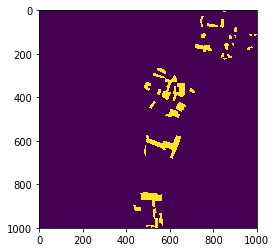

In [9]:
plt.imshow(image[4000:5000,4000:5000])

In [10]:
image[1000:5000,1000:5000].sum()

122583

In [11]:
data=image[4000:5000,4000:5000]


In [12]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(data)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=data)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=data)

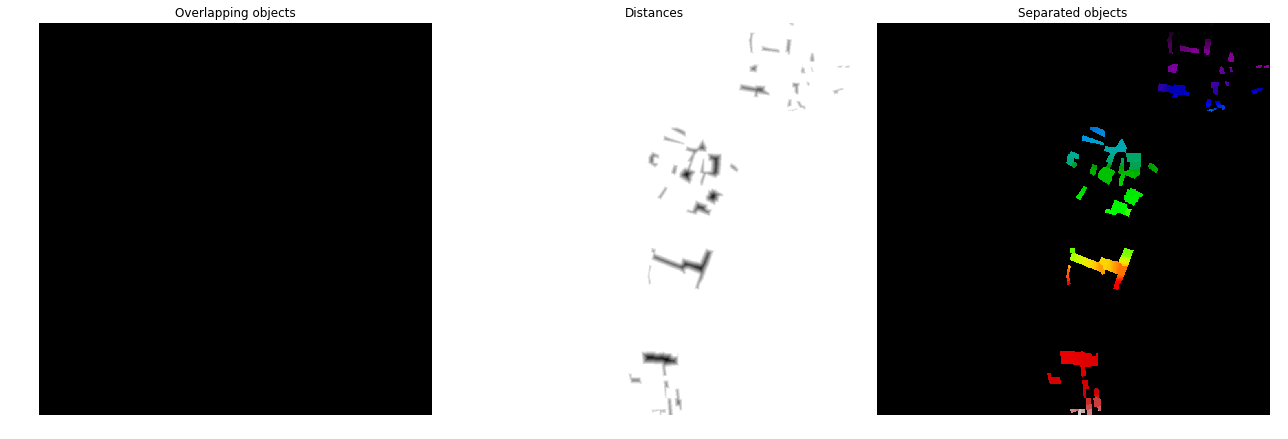

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [14]:
len(labels)

1000

In [136]:
#Trying out opencv

In [140]:
img = cv.imread("../test_data/masks/masks/20160103_66979721-be1b-4451-84e0-4a573236defd_rgb_13_21.png")

In [141]:
img.shape

(224, 224, 3)

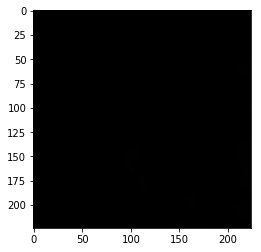

In [115]:
plt.imshow(img)

In [116]:
# Create a kernel that we will use to sharpen our image
# an approximation of second derivative, a quite strong kernel
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated
imgLaplacian = cv.filter2D(img, cv.CV_32F, kernel)
sharp = np.float32(img)
imgResult = sharp - imgLaplacian
# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)

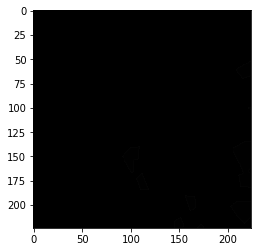

In [117]:
plt.imshow(imgResult)

In [118]:
# imgResult=cv.GaussianBlur(imgResult,(5,5),0)

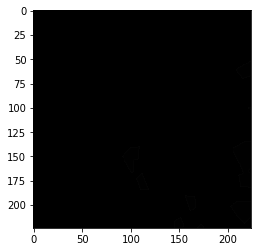

In [119]:
plt.imshow(imgResult)

In [120]:
bw = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
_, bw = cv.threshold(bw, 40, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

In [121]:
# Perform the distance transform algorithm
dist = cv.distanceTransform(bw, cv.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

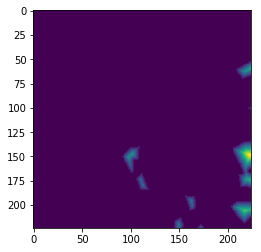

In [122]:
plt.imshow(dist)

In [123]:
# Threshold to obtain the peaks
# This will be the markers for the foreground objects
_, thresholded = cv.threshold(dist, 0.2, 1.0, cv.THRESH_BINARY)

# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dilated = cv.dilate(thresholded, kernel1)

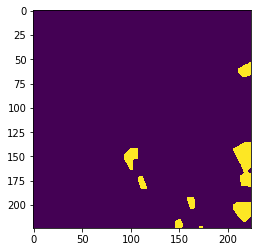

In [124]:
plt.imshow(dilated)

In [125]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dilated.astype('uint8')
# Find total markers
contours, _ = cv.findContours(dist_8u, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dilated.shape, dtype=np.int32)


# Draw the foreground markers
for i in range(len(contours)):
    cv.drawContours(markers, contours, i, (i+1), -1)

# Draw the background marker
cv.circle(markers, (5,5), 3, (255,255,255), -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [126]:
# Perform the watershed algorithm
cv.watershed(imgResult, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv.bitwise_not(mark)

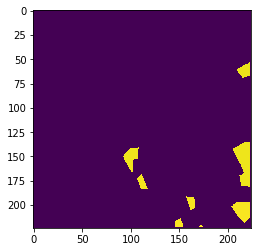

In [127]:
plt.imshow(mark)

In [128]:
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]

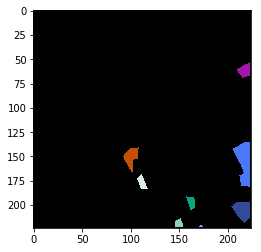

In [129]:
plt.imshow(dst)

In [130]:
markers.shape

(224, 224)

In [131]:
markers[99,22]

255

In [132]:
markers[150,100]

6

In [135]:
np.unique(markers)

array([ -1,   1,   2,   3,   4,   5,   6,   7,   8, 255], dtype=int32)

In [137]:
img = cv.imread("../test_data/masks/separated_masks/20160103_66979721-be1b-4451-84e0-4a573236defd_rgb_13_21/0.png")

In [138]:
img.shape

(224, 224, 3)